Opening an Image

In [24]:
import cv2 
from matplotlib import pyplot as plt
from PIL import Image
image='rotated_fixed.jpg'
img=cv2.imread(image)

In [25]:
#https://stackoverflow.com/questions/28816046/
#displaying-different-images-with-actual-size-in-matplotlib-subplot
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

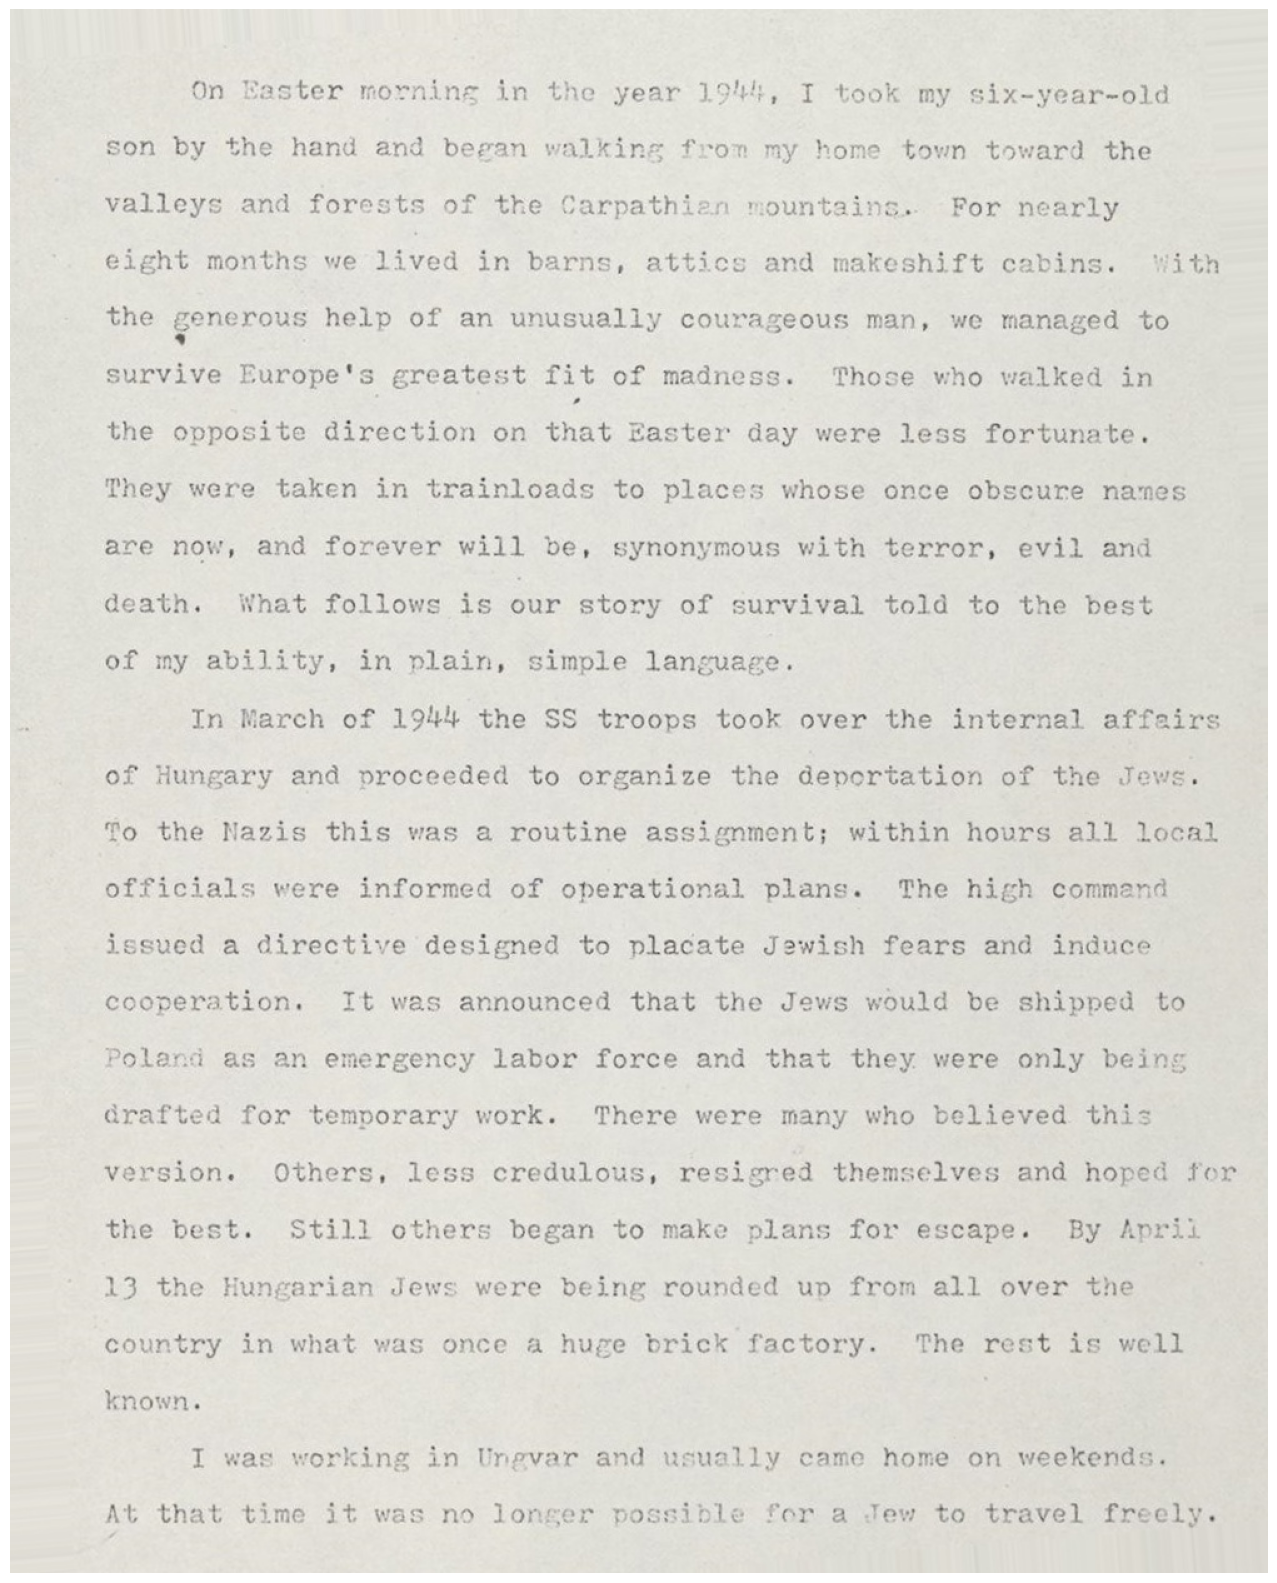

In [26]:
display(image)

01: Inverted Images

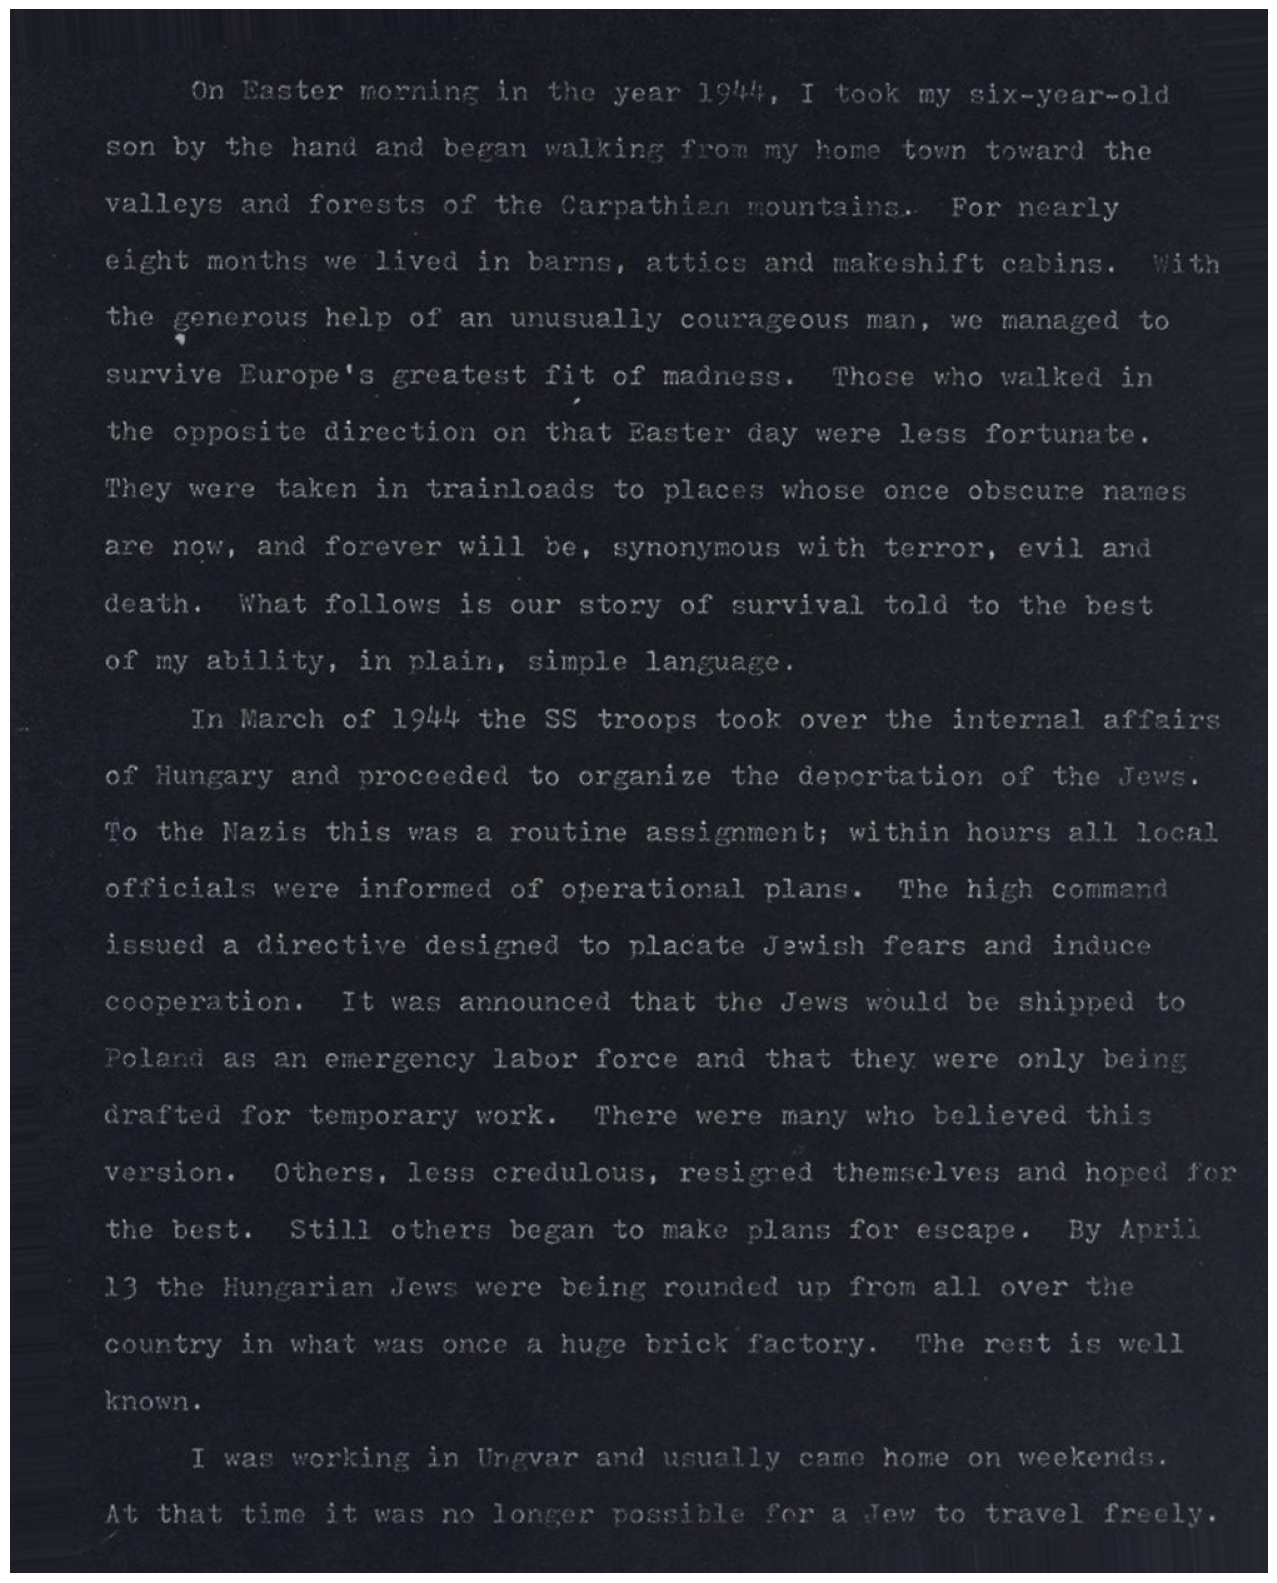

In [53]:
inverted_image=cv2.bitwise_not(img)
cv2.imwrite("image_inverted.png",inverted_image)

invert_file_name='image_inverted.png'
display(invert_file_name)

03: Binarization

In [27]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [31]:
gray_image= grayscale(img)
cv2.imwrite('image_gray.png',gray_image)

True

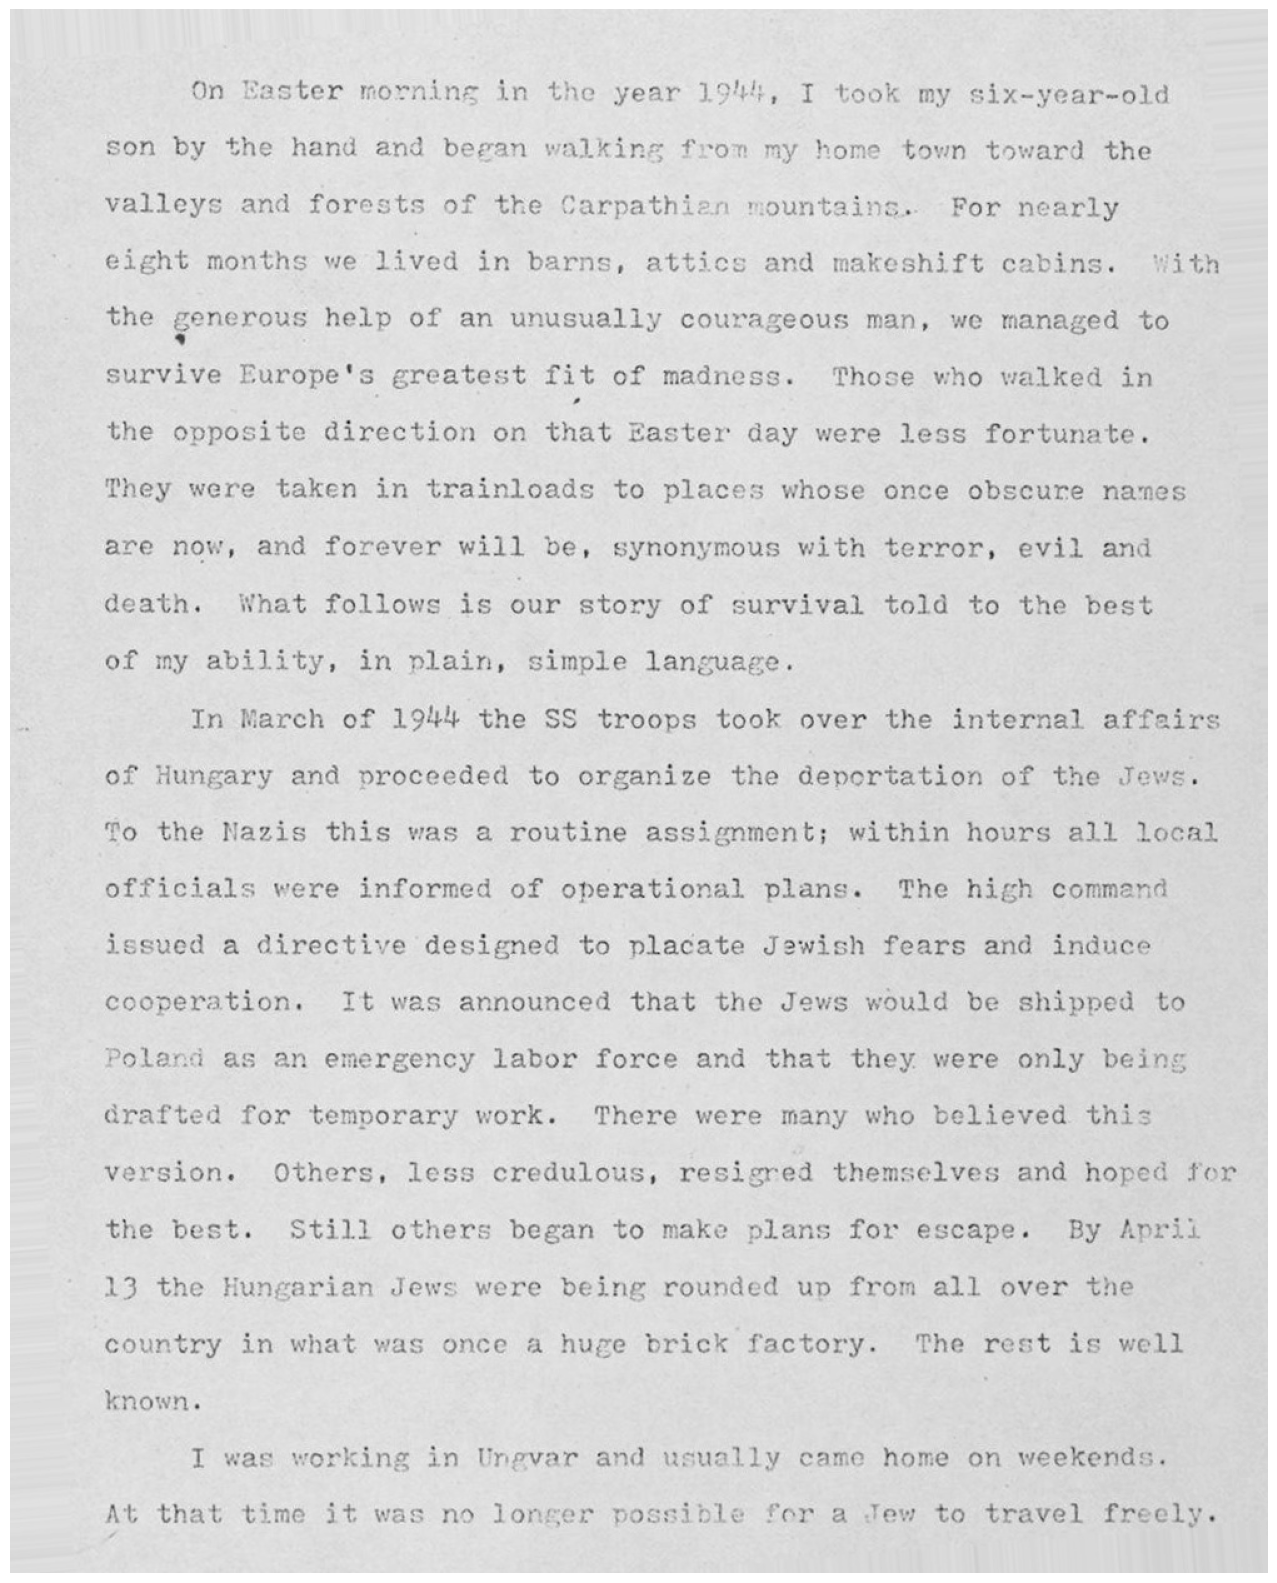

In [42]:
gray_image_file='image_gray.png'
display(gray_image_file)

Here we can USE our own ML model

In [1]:
thresh,im_bw =cv2.threshold(gray_image,100,230,cv2.THRESH_BINARY)
cv2.imwrite('image_bw.png',im_bw)
display('image_bw.png')


NameError: name 'cv2' is not defined

04: Noise Removal

In [70]:
def noise_removal(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8) # Shape of how we are capturing noice 
    image = cv2.dilate(image, kernel, iterations=1) # adds pixels
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1) # Removes pixels
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)

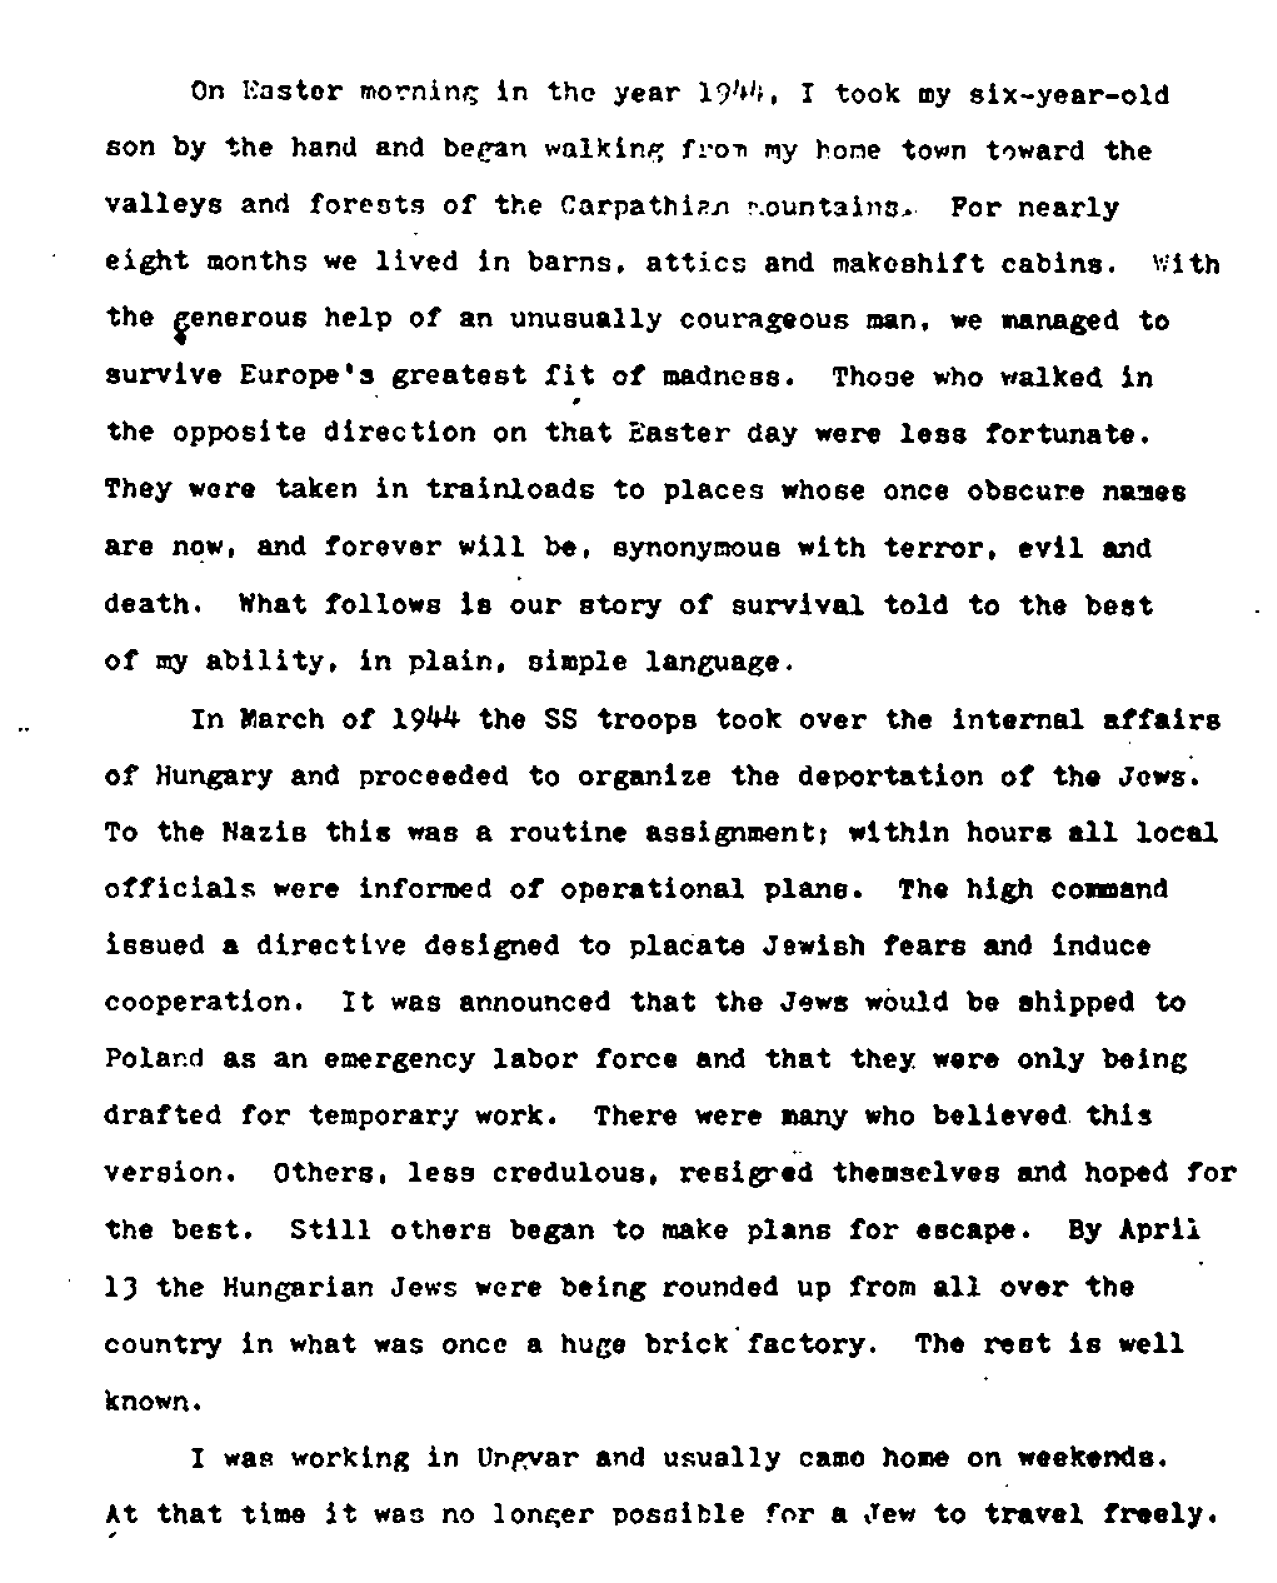

In [77]:
no_noise = noise_removal(im_bw)
cv2.imwrite("no_noise.png", no_noise)
display('no_noise.png')

05:Dilation and Erosion

In [79]:
def thin_font(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel=np.ones((1,1),np.uint8)
    image=cv2.erode(image,kernel,iterations=1)
    image=cv2.bitwise_not(image)
    return image 

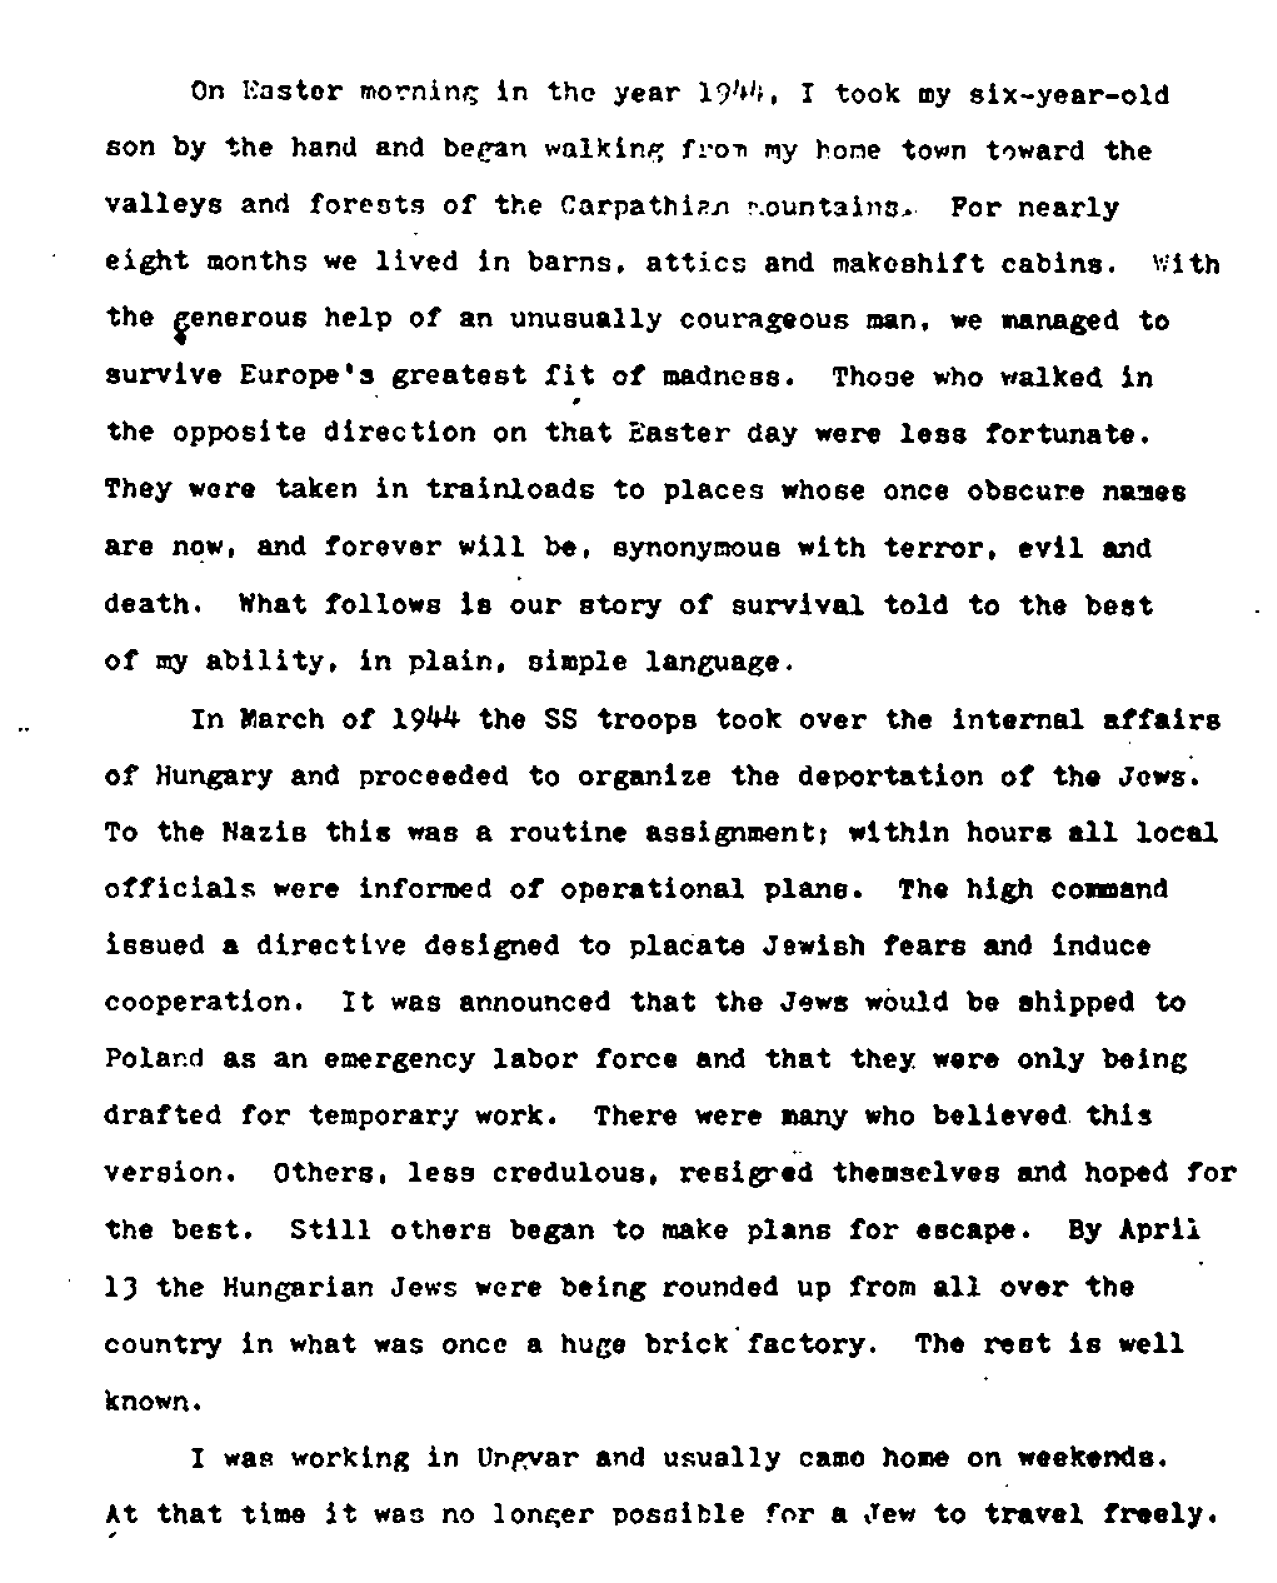

In [80]:
eroded_image=thin_font(no_noise)
cv2.imwrite('image_eroded.png',eroded_image)
display('image_eroded.png')

In [81]:
def thick_font(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel=np.ones((1,1),np.uint8)
    image=cv2.dilate(image,kernel,iterations=1)
    image=cv2.bitwise_not(image)
    return image 

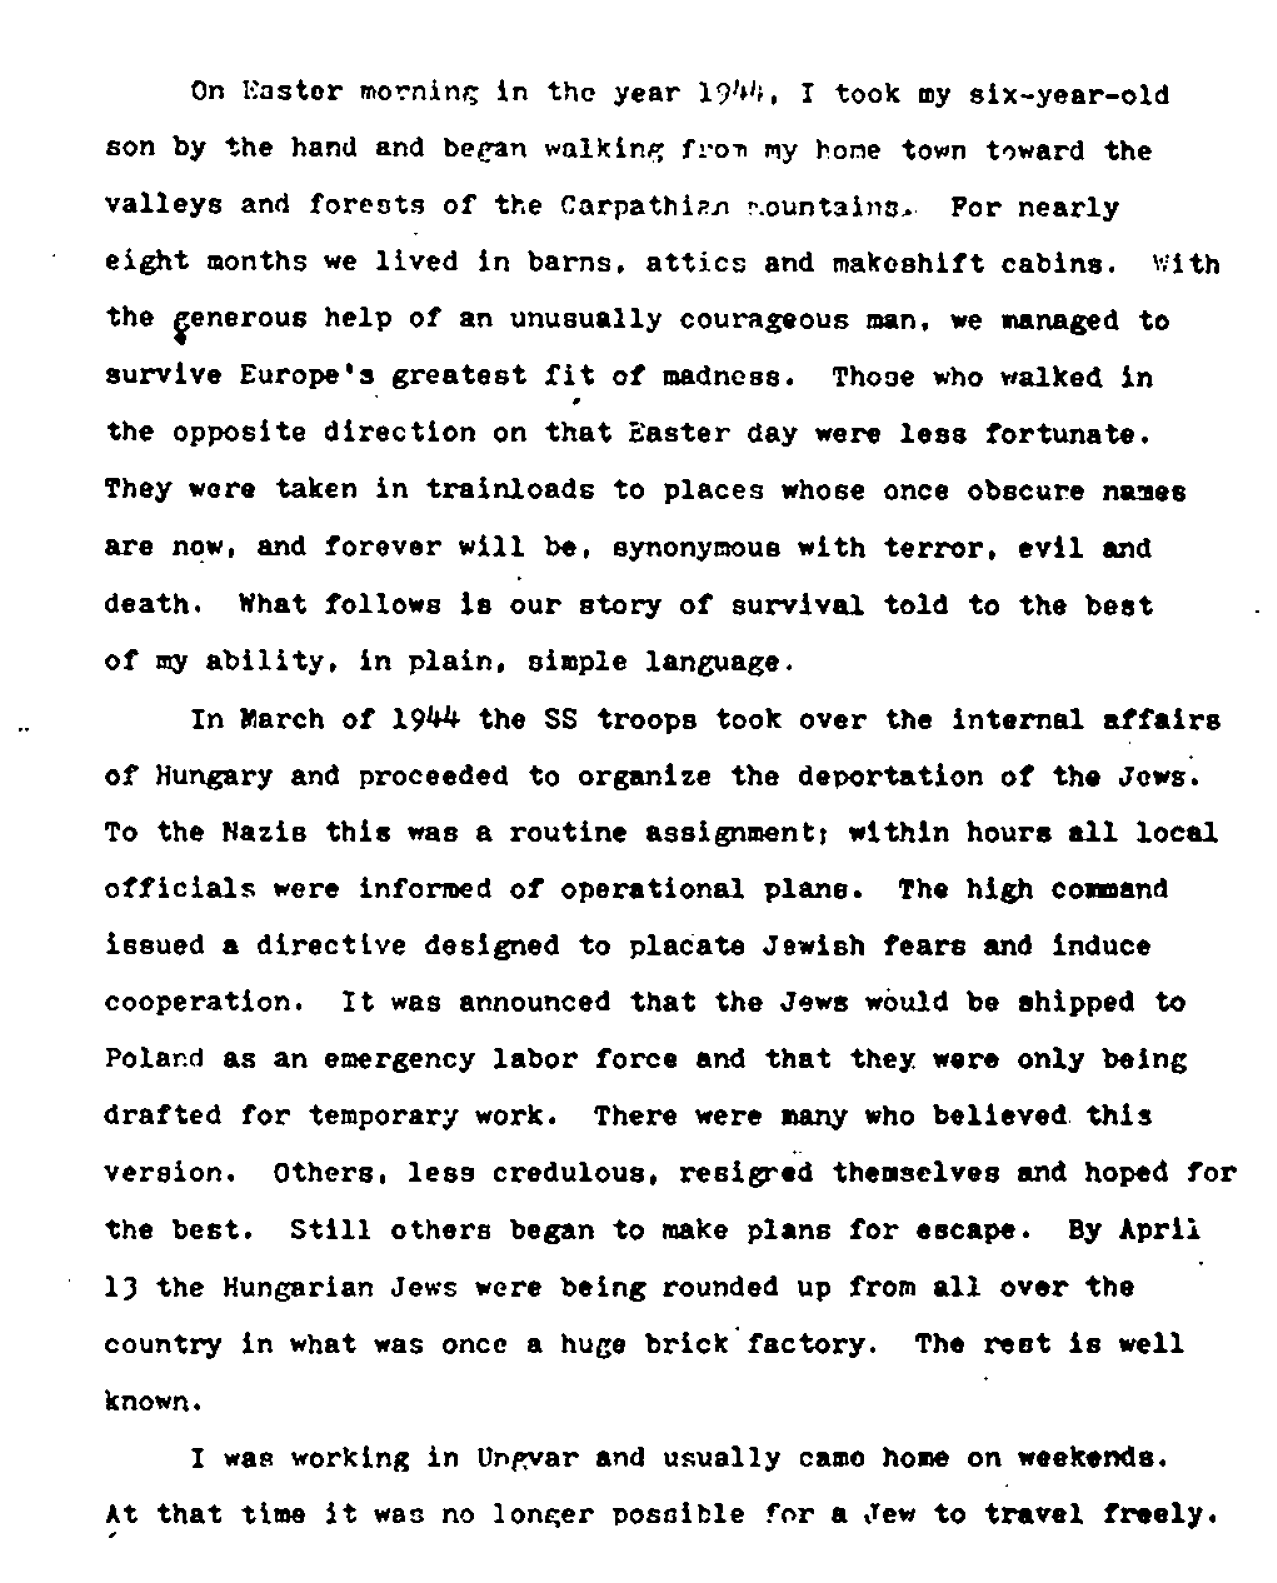

In [82]:
dilated_image=thick_font(eroded_image)
cv2.imwrite('image_dilated_after_erosion.png',dilated_image)
display('image_dilated_after_erosion.png')

06: Rotation / Deskewing

In [ ]:
#https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df
import numpy as np

def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

In [ ]:
# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

In [ ]:
display('page_01_rotated.JPG')

In [ ]:
fixed=deskew(cv2.imread('page_01_rotated.JPG'))
cv2.imwrite('rotated_fixed.jpg',fixed)

In [ ]:
display('rotated_fixed.jpg')

07: Removing Borders

In [83]:
def remove_borders(image):
    contours, heiarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv2.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

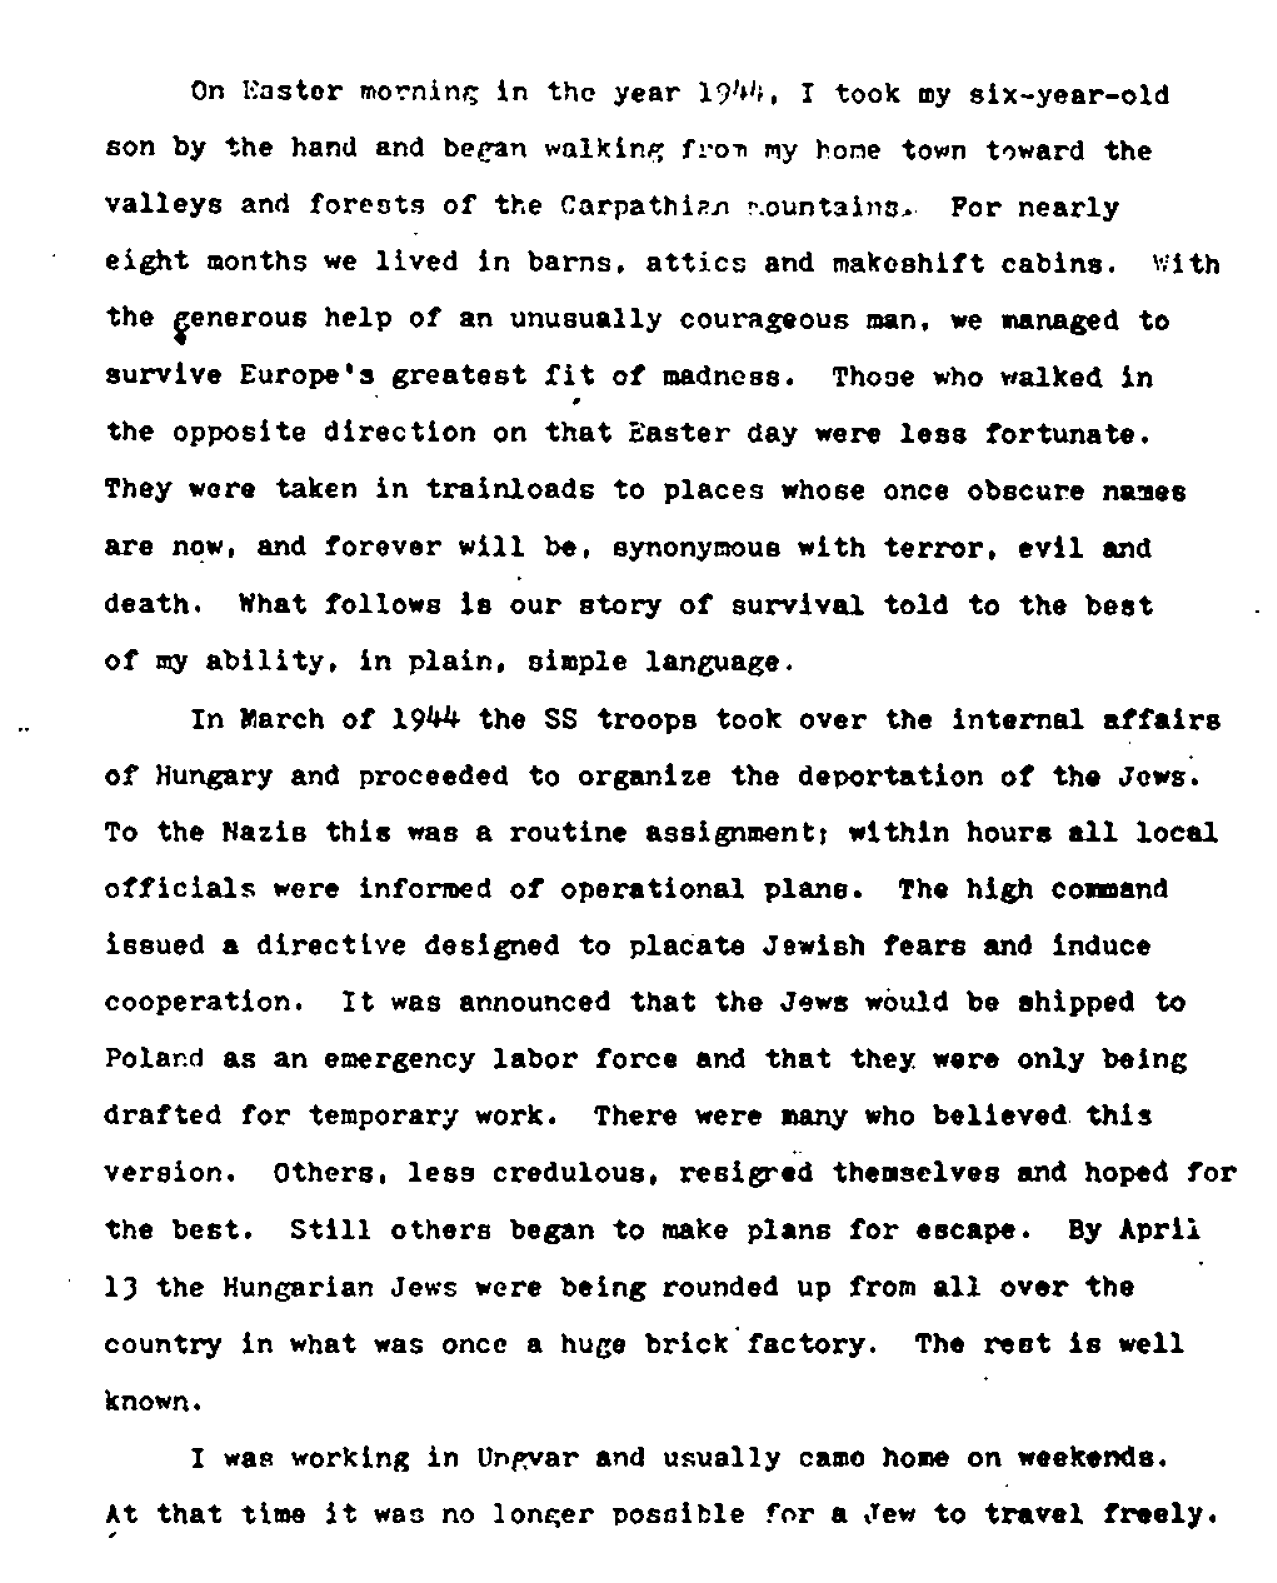

In [84]:


no_borders=remove_borders(no_noise)
cv2.imwrite('no_borders.png',no_borders)
display('no_borders.png')

08: Missing Borders

In [85]:
color = [255, 255, 255]
top, bottom, left, right = [150]*4

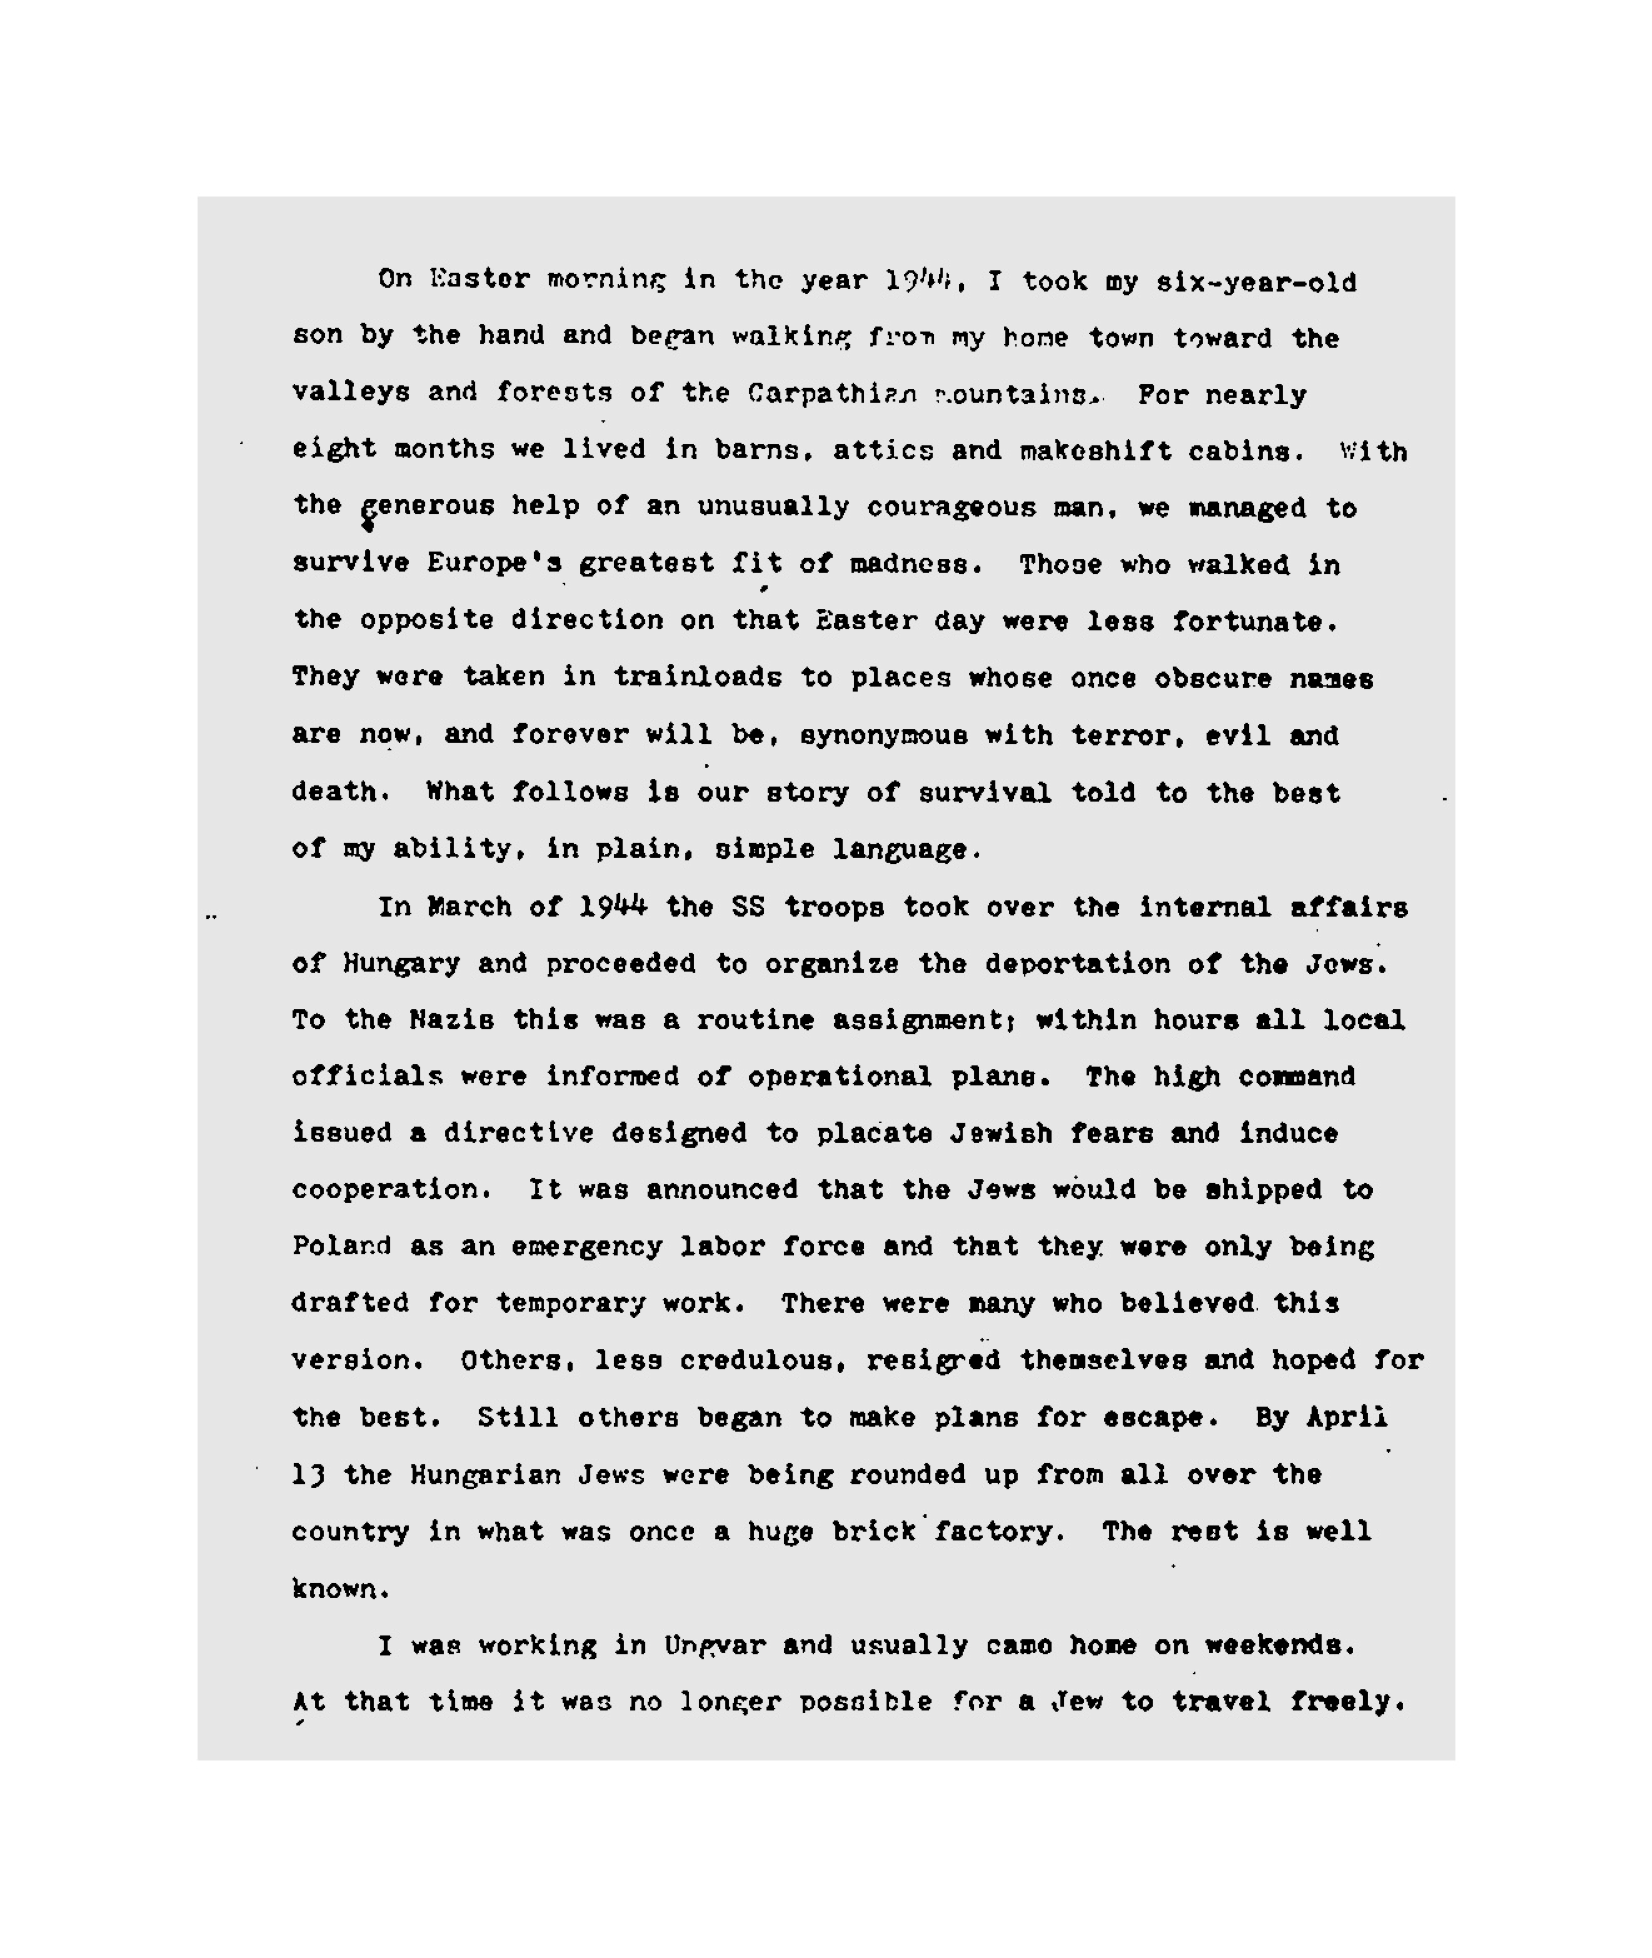

In [86]:
image_with_border = cv2.copyMakeBorder(no_borders, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
cv2.imwrite("image_with_border.jpg", image_with_border)
display("image_with_border.jpg")